In [1]:
%matplotlib inline
import xarray as xr
from glob import glob
import numpy as np
import pandas as pd
import cartopy.crs as ccrs   # map plots
import cartopy.feature as cfeature
from e3sm_utils import cmclimate
cmap_prect = cmclimate.cm.WhiteBlueGreenYellowRed
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# Fig 2: seasonal frequency of MCS
do_type = 'e3sm'
if do_type == 'e3sm':
    topdir = '/global/cscratch1/sd/crjones/ECP/e3sm'
else:
    topdir = '/global/cscratch1/sd/crjones/ECP/e3sm-mmf'
robust_files = sorted(glob(topdir + '/statstb/robust_mcs_tracks*.nc'))
nlon = 320  # len(pix_ds.lon)
nlat = 120  # len(pix_ds.lat)
seasons = ['MAM', 'JJA', 'SON']
yearly_counts = {}
print(*robust_files, sep='\n')

/global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20010301_20011031.nc
/global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20020301_20021031.nc
/global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20030301_20031031.nc


In [6]:
def link_track_to_pixel_files(this_track, pixel_files, pattern='%Y%m%d_%H%M'):
    # convert basetimes to string following pattern appearing in pixel_files names; drop NaTs
    basetimes = [bt.strftime(pattern) for bt in pd.to_datetime(this_track.base_time.values) if str(bt) != 'NaT']
    file_list = []
    for bt in basetimes:
        # tricky way to append a file matching the pattern if it's there, None if not
        file_list.append(([p for p in pixel_files if bt in p] + [None])[0])
    return file_list

def process_track(this_track, pixel_files):
    """Drop's times where base_time is NaT from this_track and 
    returns truncated this_track and pixel (map) dataSet for this track"""
    this_track = this_track.where(~np.isnat(this_track.base_time), drop=True)
    pixel_file_list = link_track_to_pixel_files(this_track, pixel_files)
    pix_ds = xr.open_mfdataset(pixel_file_list)
    return this_track, pix_ds

In [7]:
# for selection based on landfrac at initialization
ds_landfrac = xr.open_dataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science/ne120_landfrac_720x1440.nc')

def cloudtrack_and_land(pix_ds, track_id, landmask):
    da = pix_ds['cloudtracknumber']
    tot = np.count_nonzero(da == track_id)
    land = np.count_nonzero((da == track_id) & landmask)
    return land, tot

def initiates_over_land(pix_ds, track_id, landmask=None, threshold=0.05):
    if landmask is None:
        landmask = ds_landfrac['LANDFRAC'].sel(lat=pix_ds.lat, lon=pix_ds.lon) > 0.9
    land, tot = cloudtrack_and_land(pix_ds.isel(time=0), track_id, landmask)
    return (land / tot) > threshold

In [9]:
x = []
x.append(3)
print(x)
x.append(5)
print(x)

[3]
[3, 5]


In [76]:
select_only_land_inits = True
landmask = None
land_inits = {}
water_inits = {}
for robust_mcs_filename in robust_files:
    print('processing file {}'.format(robust_mcs_filename))
    stats_ds = xr.open_dataset(robust_mcs_filename)
    date_range = robust_mcs_filename[-20:-3]  # 200n0301_200n1031
    pixel_files = sorted(glob('{}/mcstracking/{}/mcstrack_*.nc'.format(topdir, date_range)))

    dat_dict = {season: np.zeros((nlat, nlon), dtype=np.int) for season in seasons}
    tracks_to_process = stats_ds.tracks.values
    # keep track of which start over land and which don't
    land_inits[date_range] = []
    water_inits[date_range] = []
    for track in tracks_to_process:
        this_track, pix_ds = process_track(stats_ds.sel(tracks=track), pixel_files)
        track_id = track + 1
        if landmask is None:
            landmask = ds_landfrac['LANDFRAC'].sel(lat=pix_ds.lat, lon=pix_ds.lon) > 0.9
        if select_only_land_inits:
            if not initiates_over_land(pix_ds, track_id, landmask=landmask):
                water_inits[date_range].append(track_id)
                print('skipping track ', track_id)
            else:
                land_inits[date_range].append(track_id)
                da = (pix_ds['cloudtracknumber'] == track_id).groupby('time.season').sum(dim='time').load()
                for season in da.season.values:
                    dat_dict[season] += (da.sel(season=season).values > 0).astype(int)
    yearly_counts[date_range] = dat_dict

processing file /global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20010301_20011031.nc
skipping track  4
skipping track  7
skipping track  13
skipping track  19
skipping track  26
skipping track  29
skipping track  30
skipping track  38
skipping track  41
skipping track  45
skipping track  54
skipping track  55
skipping track  56
skipping track  57
skipping track  58
skipping track  59
skipping track  60
skipping track  61
skipping track  62
skipping track  63
processing file /global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20020301_20021031.nc
skipping track  4
skipping track  5
skipping track  6
skipping track  9
skipping track  13
skipping track  16
skipping track  17
skipping track  19
skipping track  21
skipping track  22
skipping track  28
skipping track  29
skipping track  36
skipping track  37
skipping track  41
skipping track  44
skipping track  45
skipping track  47
skipping track  49
skipping track  55
skipping track  57
skipping track  58
skippi

In [77]:
for key in sorted(land_inits.keys()):
    print(key, len(land_inits[key]), len(water_inits[key]))

20010301_20011031 47 20
20020301_20021031 43 26
20030301_20031031 52 10


In [78]:
# write dataset to file
# dimesions: either (year, season, lat, lon) or (time, lat, lon)
lons = pix_ds.lon
lats = pix_ds.lat
if 'e3sm-mmf' in topdir:
    years = pd.date_range(start='2001', end='2008', freq='A-JUN')
else:
    years = pd.date_range(start='2001', end='2004', freq='A-JUN')
years

DatetimeIndex(['2001-06-30', '2002-06-30', '2003-06-30'], dtype='datetime64[ns]', freq='A-JUN')

In [79]:
data = np.empty((len(years), len(seasons), len(lats), len(lons)), dtype=np.int)

In [80]:
sorted_keys = sorted([k for k in yearly_counts.keys()])
for ny, yr in enumerate(sorted_keys):
    for ns, season in enumerate(seasons):
        data[ny, ns, :, :] = yearly_counts[yr][season]

In [81]:
print(max(v[-1] for v in land_inits.values()))
print(max(v[-1] for v in water_inits.values()))

67
69


In [22]:
tracks - 1

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [20]:
print(min(v[0] for v in land_inits.values()))
print(min(v[0] for v in water_inits.values()))

1
1


In [82]:
tracks = np.arange(1, 311, dtype=np.int)
print(tracks)
iland = 1
iwater = 2
# track_output:
track_data = np.zeros((len(years), len(tracks)), dtype=np.int)
for ny, yr in enumerate(sorted_keys):
    land_vals = np.array(land_inits[yr], dtype=np.int) - 1
    nonland_vals = np.array(water_inits[yr], dtype=np.int) - 1
    track_data[ny, land_vals] = iland
    track_data[ny, nonland_vals] = iwater
track_data[0, :]

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

array([1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [83]:
da_tracks = xr.DataArray(track_data, coords=[years, tracks],
                         dims=['year', 'track'],
                         name='init_loc',
                         attrs={'units': 'None', 
                                'long_name': 'initiation_location',
                                'notes': '1 = initiates over land, 2 = initiates over water, 0 = no track'}
                        )
da_tracks

<xarray.DataArray 'init_loc' (year: 3, track: 310)>
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [2, 1, 1, ..., 0, 0, 0]])
Coordinates:
  * year     (year) datetime64[ns] 2001-06-30 2002-06-30 2003-06-30
  * track    (track) int64 1 2 3 4 5 6 7 8 9 ... 303 304 305 306 307 308 309 310
Attributes:
    units:      None
    long_name:  initiation_location
    notes:      1 = initiates over land, 2 = initiates over water, 0 = no track

In [84]:
da = xr.DataArray(data, coords=[years, seasons, lats, lons],
                  dims=['year', 'season', 'lat', 'lon'],
                  name='seasonal_mcs_count',
                  attrs={'units': 'None', 
                         'long_name': 'seasonal_mcs_count',
                         'notes': 'excludes tracks that do not initiate over land'},
                 )
da

<xarray.DataArray 'seasonal_mcs_count' (year: 3, season: 3, lat: 120, lon: 320)>
array([[[[0, ..., 0],
         ...,
         [0, ..., 0]],

        ...,

        [[0, ..., 0],
         ...,
         [0, ..., 0]]],


       ...,


       [[[0, ..., 0],
         ...,
         [0, ..., 0]],

        ...,

        [[0, ..., 0],
         ...,
         [0, ..., 0]]]])
Coordinates:
  * year     (year) datetime64[ns] 2001-06-30 2002-06-30 2003-06-30
  * season   (season) <U3 'MAM' 'JJA' 'SON'
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 220.125 220.375 220.625 ... 299.375 299.625 299.875
Attributes:
    units:      None
    long_name:  seasonal_mcs_count
    notes:      excludes tracks that do not initiate over land

In [85]:
ds0 = xr.merge([da, da_tracks])
ds0

<xarray.Dataset>
Dimensions:             (lat: 120, lon: 320, season: 3, track: 310, year: 3)
Coordinates:
  * year                (year) datetime64[ns] 2001-06-30 2002-06-30 2003-06-30
  * season              (season) <U3 'MAM' 'JJA' 'SON'
  * lat                 (lat) float32 20.125 20.375 20.625 ... 49.625 49.875
  * lon                 (lon) float32 220.125 220.375 ... 299.625 299.875
  * track               (track) int64 1 2 3 4 5 6 7 ... 305 306 307 308 309 310
Data variables:
    seasonal_mcs_count  (year, season, lat, lon) int64 0 0 0 0 0 0 ... 0 0 0 0 0
    init_loc            (year, track) int64 1 1 1 2 1 1 2 1 ... 0 0 0 0 0 0 0 0

In [86]:
ds0.to_netcdf(topdir + '/seasonal_mcs_count_land_only.nc')

In [87]:
dsx = ds0

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


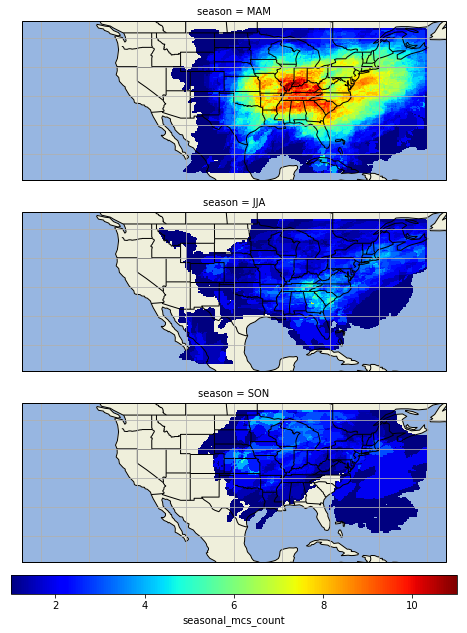

In [4]:
# E3SM
dsx = xr.open_dataset(topdir + '/seasonal_mcs_count_land_only.nc')

# dat = dsx['seasonal_mcs_count'].astype(np.float)
dat = dsx['seasonal_mcs_count']
dat = dat.where(dat > 0)
# dat.values[dat.values <1e-3] = np.nan
# levs = range(2, 18, 2)
p = dat.mean(dim='year').plot(row='season', transform=ccrs.PlateCarree(),
                              subplot_kws={'projection': ccrs.PlateCarree()},
                              cbar_kwargs={'orientation': 'horizontal', 'pad': 0.02, 'aspect': 24},
                              cmap=plt.cm.jet, figsize=(8, 12),
                              # levels=levs
                             )
for ax in p.axes.flat:
    ax.add_feature(states_provinces, edgecolor='black', alpha=1)
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    ax.gridlines()

In [10]:
da.to_netcdf(topdir + '/seasonal_mcs_count.nc')

In [11]:
dsx = xr.open_dataset(topdir + '/seasonal_mcs_count.nc')
dsx

<xarray.Dataset>
Dimensions:             (lat: 120, lon: 320, season: 3, year: 3)
Coordinates:
  * year                (year) datetime64[ns] 2001-06-30 2002-06-30 2003-06-30
  * season              (season) object 'MAM' 'JJA' 'SON'
  * lat                 (lat) float32 20.125 20.375 20.625 ... 49.625 49.875
  * lon                 (lon) float32 220.125 220.375 ... 299.625 299.875
Data variables:
    seasonal_mcs_count  (year, season, lat, lon) int64 ...

In [12]:
np.all(dsx['seasonal_mcs_count'].values == da.values)

True

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


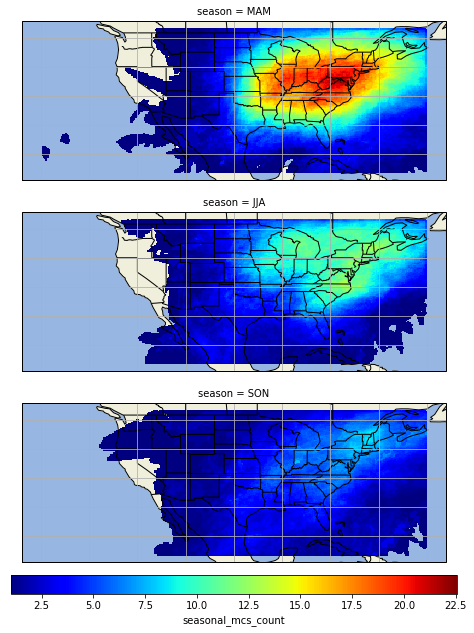

In [5]:
# E3SM-MMF: 
ds_mmf = xr.open_dataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/seasonal_mcs_count_land_only.nc')
# dat = dsx['seasonal_mcs_count'].astype(np.float)
dat = ds_mmf['seasonal_mcs_count']
dat = dat.where(dat > 0)
# dat.values[dat.values <1e-3] = np.nan
# levs = range(2, 17, 1)
p = dat.mean(dim='year').plot(row='season', transform=ccrs.PlateCarree(),
                                                subplot_kws={'projection': ccrs.PlateCarree()},
                                                cbar_kwargs={'orientation': 'horizontal', 'pad': 0.02, 'aspect': 24},
                                                cmap=plt.cm.jet, figsize=(8, 12),
                                                # levels=levs,
                                               )
for ax in p.axes.flat:
    ax.add_feature(states_provinces, edgecolor='black', alpha=1)
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    ax.gridlines()

In [3]:
# prepare figure canvas:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


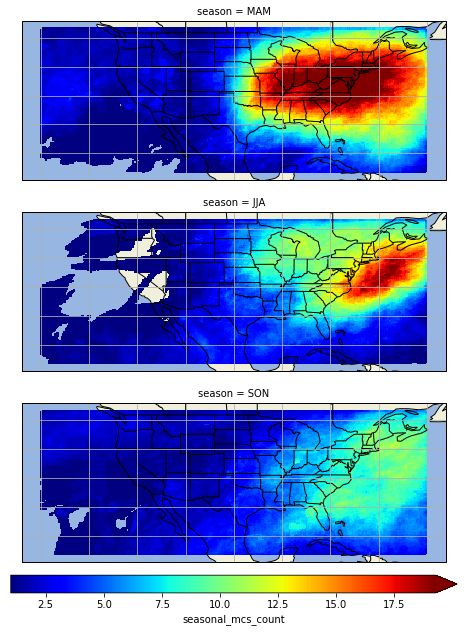

In [29]:
# MMF
ds_mmf = xr.open_dataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/seasonal_mcs_count.nc')
dat = ds_mmf['seasonal_mcs_count']
dat = dat.where(dat > 0)
p = dat.mean(dim='year').plot(row='season', transform=ccrs.PlateCarree(),
                              subplot_kws={'projection': ccrs.PlateCarree()},
                              cbar_kwargs={'orientation': 'horizontal', 'pad': 0.02, 'aspect': 24},
                              cmap=plt.cm.jet, figsize=(8, 12), robust=True,
                             )
for ax in p.axes.flat:
    ax.add_feature(states_provinces, edgecolor='black', alpha=1)
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    ax.gridlines()

In [1]:
lats = pix_ds.lat.values
lons = pix_ds.lon.values
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()})
for (season, ax) in zip(seasons, axes.flat):
    p = ax.pcolor(lons, lats, dat_dict[season], cmap=plt.cm.jet)
    plt.colorbar(p)

NameError: name 'pix_ds' is not defined

## Figure 4: Grouped by Region

In [31]:
import shapely.geometry as sgeom
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from shapely.prepared import prep

In [3]:
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
"""    for state in shpreader.Reader(states_shp).geometries():
        # pick a default color for the land with a black outline,
        # this will change if the storm intersects with our track
        facecolor = [0.9375, 0.9375, 0.859375]
        edgecolor = 'black'

        if state.intersects(track):
            facecolor = 'red'
        elif state.intersects(track_buffer):
            facecolor = '#FF7E00'

        ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor)

    ax.add_geometries([track_buffer], ccrs.PlateCarree(),
                      facecolor='#C8A2C8', alpha=0.5)
    ax.add_geometries([track], ccrs.PlateCarree(),
                      facecolor='none')

    # make two proxy artists to add to a legend
    direct_hit = mpatches.Rectangle((0, 0), 1, 1, facecolor="red")
    within_2_deg = mpatches.Rectangle((0, 0), 1, 1, facecolor="#FF7E00")
    labels = ['State directly intersects\nwith track',
              'State is within \n2 degrees of track']
    plt.legend([direct_hit, within_2_deg], labels,
               loc='lower left', bbox_to_anchor=(0.025, -0.1), fancybox=True)

    plt.show()
"""

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces_lakes_shp.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


'    for state in shpreader.Reader(states_shp).geometries():\n        # pick a default color for the land with a black outline,\n        # this will change if the storm intersects with our track\n        facecolor = [0.9375, 0.9375, 0.859375]\n        edgecolor = \'black\'\n\n        if state.intersects(track):\n            facecolor = \'red\'\n        elif state.intersects(track_buffer):\n            facecolor = \'#FF7E00\'\n\n        ax.add_geometries([state], ccrs.PlateCarree(),\n                          facecolor=facecolor, edgecolor=edgecolor)\n\n    ax.add_geometries([track_buffer], ccrs.PlateCarree(),\n                      facecolor=\'#C8A2C8\', alpha=0.5)\n    ax.add_geometries([track], ccrs.PlateCarree(),\n                      facecolor=\'none\')\n\n    # make two proxy artists to add to a legend\n    direct_hit = mpatches.Rectangle((0, 0), 1, 1, facecolor="red")\n    within_2_deg = mpatches.Rectangle((0, 0), 1, 1, facecolor="#FF7E00")\n    labels = [\'State directly inters

In [22]:
reader = shpreader.Reader(states_shp)
states = reader.records()

In [20]:
sgp_states = ['New Mexico', 'Texas', 'Oklahoma', 'Arkansas']
southeast_states = ['Louisiana', 'Mississippi', 'Alabama', 'Georgia', 'Florida', 'South Carolina', 'North Carolina']
ngp_states = ['Montana', 'Wyoming', 'Colorado', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas',
              'Minnesota', 'Iowa', 'Missouri', 'Wisconsin', 'Illinois', 'Indiana']

In [23]:
state_names = [state.attributes['name'] for state in states]

In [26]:
all(s in state_names for s in ngp_states)

True

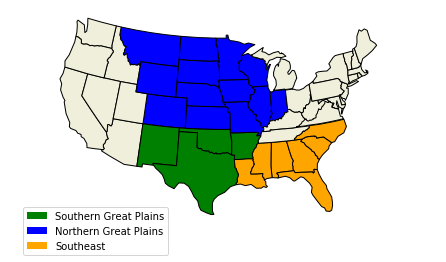

In [30]:
ax = plt.axes([0, 0, 1, 1],
              projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# to get the effect of having just the states without a map "background"
# turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

for rec, state in zip(shpreader.Reader(states_shp).records(), shpreader.Reader(states_shp).geometries()):
    
    # pick a default color for the land with a black outline,
    facecolor = [0.9375, 0.9375, 0.859375]
    edgecolor = 'black'

    if rec.attributes['name'] in sgp_states:
        facecolor = 'green'
    elif rec.attributes['name'] in ngp_states:
        facecolor = 'blue'
    elif rec.attributes['name'] in southeast_states:
        facecolor = 'orange'

    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor)
    
# make proxy artists to add to a legend
sgp = mpatches.Rectangle((0, 0), 1, 1, facecolor="green")
ngp = mpatches.Rectangle((0, 0), 1, 1, facecolor="blue")
seast = mpatches.Rectangle((0, 0), 1, 1, facecolor="orange")
plt.legend([sgp, ngp, seast], ['Southern Great Plains', 'Northern Great Plains', 'Southeast'],
           loc='lower left', bbox_to_anchor=(0.025, -0.1), fancybox=True);

In [ ]:
# next up: count tracks up by month, find those that live inside the right place ... not sure if it'll use 'intersect' as in the 
# Katrina example, or some other fancy stuff.
# Katrina example: https://scitools.org.uk/cartopy/docs/v0.15/examples/hurricane_katrina.html
#
# This might also be useful ...
# https://stackoverflow.com/questions/47894513/checking-if-a-geocoordinate-point-is-land-or-ocean-with-cartopy

In [32]:
region_geoms = {}
for key, val in {'sgp': sgp, 'ngp': ngp, 'seast': seast}.items():
    rgn_geoms = unary_union([geom for rec, geom in zip(shpreader.Reader(states_shp).records(), shpreader.Reader(states_shp).geometries()) if rec.attributes['name'] in val])
    region_geoms[key] = prep(rgn_geoms)

TypeError: argument of type 'Rectangle' is not iterable

In [49]:
geoms = [g for g in shpreader.Reader(states_shp).geometries()]
recs = [r for r in shpreader.Reader(states_shp).records()]

In [69]:
region_geoms = {}
for key, val in {'sgp': sgp_states, 'ngp': ngp_states, 'seast': southeast_states}.items():
    rgn_geoms = unary_union([rec.geometry for rec in recs if rec.attributes['name'] in val])
    region_geoms[key] = prep(rgn_geoms)

In [72]:
sgp_geom = region_geoms['sgp']

In [87]:
rgn_geoms.contains(sgeom.Point(-82, 35))

True

In [60]:
for rec, geom in zip(recs, geoms):
    print(rec)
    print(geom)

Record(MULTIPOLYGON (((-92.01192239021231 46.71171747412134, -92.27487891311996 46.65614472104868, -92.2648278470392 46.09522288673648, -92.29658301468254 46.09628225359845, -92.54369971390231 45.98569468849387, -92.75696834997083 45.88991242124089, -92.89982784704181 45.7057634547687, -92.68922054723622 45.51843638771071, -92.76541744665064 45.26708222104298, -92.76647681351261 44.9961426865367, -92.79665584997099 44.77602692318951, -92.50507158076411 44.58391978614448, -92.38549231644073 44.57492808692568, -92.06215287959044 44.43258535417777, -91.949989183301 44.36483755144306, -91.87960588251947 44.25742808692438, -91.62770911331276 44.08544892025706, -91.28959021682704 43.93729258887625, -91.25729244664454 43.85473948829003, -91.25465694859771 43.61397899024215, -91.22819861526422 43.50124685319744, -92.54000484899343 43.51977285417402, -94.00102678096543 43.51341665300222, -95.35993608272867 43.50018748633538, -96.45266008175646 43.50178945573643, -96.4394309150898 44.43576345476

In [40]:
tmp = geoms[3]

In [52]:
recs[3].attributes

{'scalerank': 2,
 'featurecla': 'Admin-1 scale rank',
 'adm1_code': 'USA-3517',
 'diss_me': 3517,
 'adm1_cod_1': 'USA-3517',
 'iso_3166_2': 'US-HI',
 'wikipedia': 'http://en.wikipedia.org/wiki/Hawaii',
 'sr_sov_a3': 'US1',
 'sr_adm0_a3': 'USA',
 'iso_a2': 'US',
 'adm0_sr': 8,
 'admin0_lab': 2,
 'name': 'Hawaii',
 'name_alt': 'HI|Hawaii',
 'name_local': '',
 'type': 'State',
 'type_en': 'State',
 'code_local': 'US15',
 'code_hasc': 'US.HI',
 'note': '',
 'hasc_maybe': '',
 'region': 'West',
 'region_cod': '',
 'region_big': 'Pacific',
 'big_code': '',
 'provnum_ne': 0,
 'gadm_level': 1,
 'check_me': 0,
 'scaleran_1': 2,
 'datarank': 1,
 'abbrev': 'Hawaii',
 'postal': 'HI',
 'area_sqkm': 0.0,
 'sameascity': -99,
 'labelrank': 0,
 'featurec_1': 'Admin-1 scale rank',
 'admin': 'United States of America',
 'name_len': 6,
 'mapcolor9': 1,
 'mapcolor13': 1}

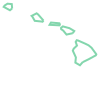

In [45]:
tmp.

In [ ]:
for rec, state in zip(shpreader.Reader(states_shp).records(), shpreader.Reader(states_shp).geometries()):

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)
    